# Setup

In [ ]:
!pip install scanpy -q
! pip install igraph -q
! pip install louvain -q

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import sklearn

In [ ]:
bsub_1_file = '/kushina_files/GSM4594095_mRNA_M14_200.csv'
bsub_1_od_file = '/kushina_files/GSM4594095_mRNA_M14_ODannotation.csv'
bsub_1_gene_names_file ='/kushina_files/GSM4594095_mRNA_M14_gene_names.csv'

bsub_2_file = '/kushina_files/GSM4594096_mRNA_M15_200.csv'
bsub_2_od_file = '/kushina_files/GSM4594096_mRNA_M15_ODannotation.csv'
bsub_2_gene_names_file = '/kushina_files/GSM4594096_mRNA_M15_gene_names.csv'

bsub_ecoli_file = '/kushina_files/GSM4594094_M11_dcm.csv'
bsub_ecoli_barcodes_file = '/kushina_files/GSM4594094_M11_barcodes.csv'
bsub_ecoli_genes_file = '/kushina_files/GSM4594094_M11_genes.csv'

# Processing of B. subtilis Data from the Growth in Rich Media Experiment

In [ ]:
bsub1 = sc.read_csv(bsub_1_file, delimiter=',', first_column_names=None, dtype='float32')
bsub2 = sc.read_csv(bsub_2_file, delimiter=',', first_column_names=None, dtype='float32')

In [ ]:
# growth stages
od1 = pd.read_csv(bsub_1_od_file,header=None) 
od2 = pd.read_csv(bsub_2_od_file,header=None) 

gene_names1 =  pd.read_csv(bsub_1_gene_names_file,header=None) 
gene_names2 =  pd.read_csv(bsub_2_gene_names_file,header=None) 

bsub1.obs['od'] = od1.to_numpy()
bsub1.var['gene_names'] = gene_names1.to_numpy()

bsub2.obs['od'] = od2.to_numpy()
bsub2.var['gene_names'] = gene_names2.to_numpy()

In [ ]:
bsub1_copy = bsub1.copy()
bsub1_copy

AnnData object with n_obs × n_vars = 25446 × 3769
    obs: 'od'
    var: 'gene_names'

In [ ]:
bsub2_copy = bsub2.copy()
bsub2_copy

AnnData object with n_obs × n_vars = 10972 × 3666
    obs: 'od'
    var: 'gene_names'

In [ ]:
# merge exp1 and exp2 data
bsub = bsub1_copy.concatenate(bsub2_copy, index_unique=None)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
sc.pp.calculate_qc_metrics(bsub,inplace=True)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


In [ ]:
x = bsub.obs['od'].to_numpy();
od_values = np. unique(x)
print(od_values)

bsub_filtered = bsub.copy()
for od in od_values:
  t = np.array([(g == od) for g in bsub.obs['od']])
  idx = [i for i, x in enumerate(t) if x]
  counts = [bsub.obs['log1p_total_counts'][i] for i in idx]
  count_min = np.percentile(counts, 35)
  filter_idx = [idx[i] for i,x in enumerate(counts) if x < count_min]
  filter_idx = np.array(filter_idx)

  select = np.in1d(range(bsub_filtered.shape[0]), filter_idx)
  bsub_filtered = bsub_filtered[~select,:]

bsub_filtered

['OD0.4' 'OD0.5' 'OD1.0' 'OD1.3' 'OD1.6' 'OD1.7' 'OD2.0' 'OD2.7' 'OD2.8'
 'OD3.2' 'OD3.6' 'OD5.3' 'OD6.0']


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 25803 × 3666
    obs: 'od', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names-0', 'gene_names-1', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


98.15743255615234


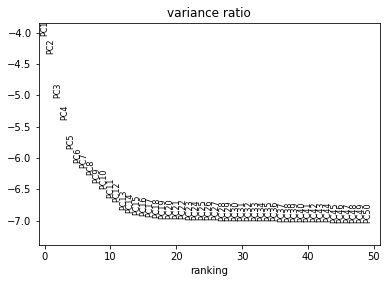

In [ ]:
bsub_processed = bsub_filtered.copy()

mean_n_count = np.mean(bsub_processed.obs["total_counts"])
print(mean_n_count)
sc.pp.normalize_total(bsub_processed, target_sum=mean_n_count, copy=False)

sc.pp.log1p(bsub_processed)
sc.pp.scale(bsub_processed, max_value=10)
sc.tl.pca(bsub_processed, svd_solver='arpack')
sc.pl.pca_variance_ratio(bsub_processed, log=True, n_pcs=50, save='') 

# ComBat batch correction

In [ ]:
bsub_batch_corrected =  bsub_processed.copy()
sc.pp.combat(bsub_batch_corrected, key='batch', covariates=None, inplace=True)

sc.pp.neighbors(bsub_batch_corrected, n_neighbors=8, n_pcs=16)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Found 3 genes with zero variance.


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


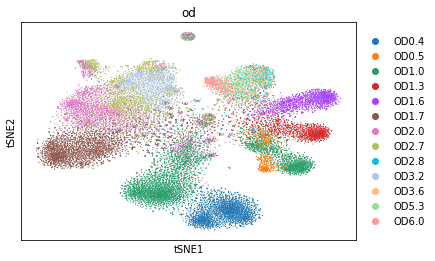

In [ ]:
sc.tl.tsne(bsub_batch_corrected)
sc.pl.tsne(bsub_batch_corrected,color='od')

In [ ]:
sc.tl.louvain(bsub_batch_corrected, resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(bsub_batch_corrected, resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(bsub_batch_corrected, resolution = 0.8, key_added = "louvain_0.8")
sc.tl.louvain(bsub_batch_corrected, resolution = 1, key_added = "louvain_r1")

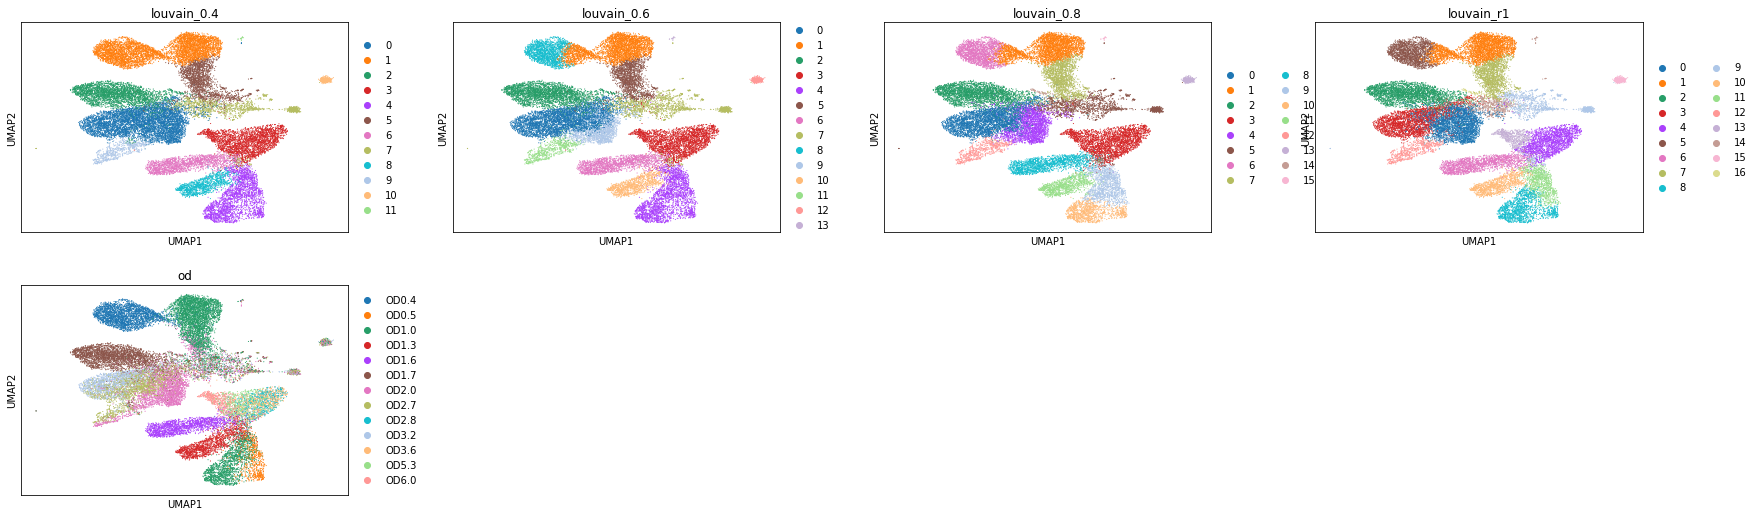

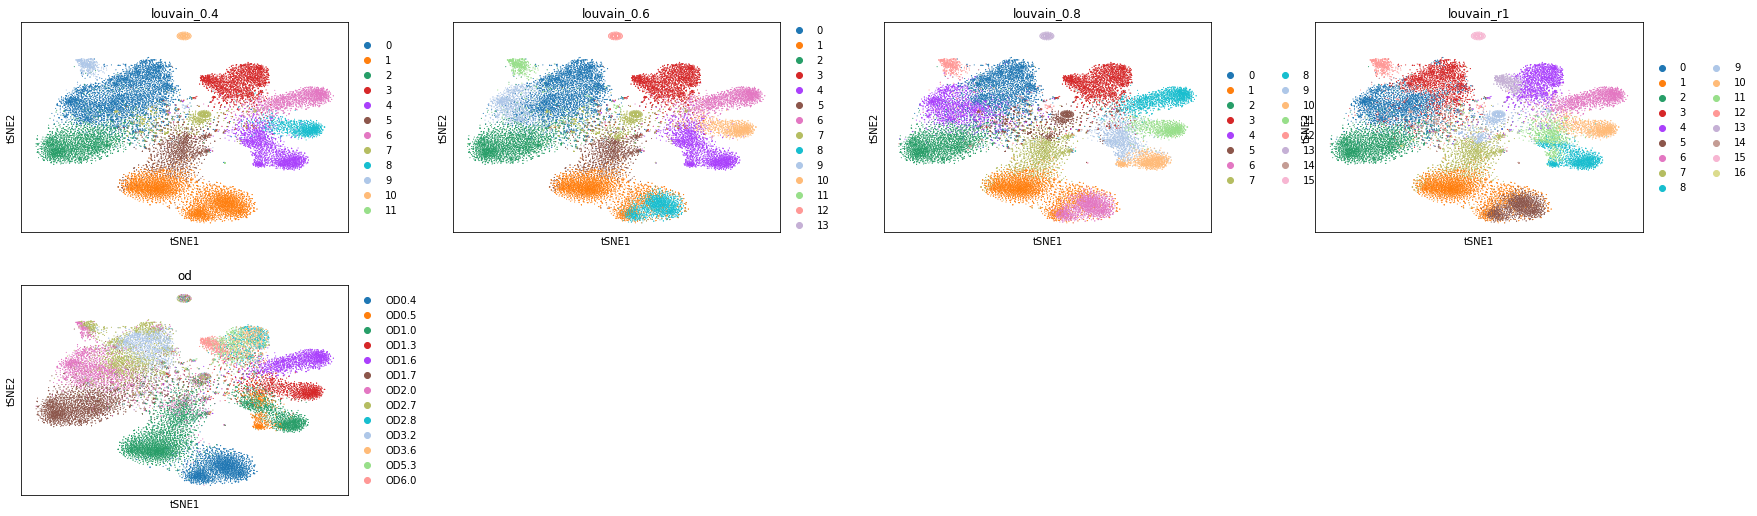

In [ ]:
sc.tl.umap(bsub_batch_corrected)
sc.pl.umap(bsub_batch_corrected, color=['louvain_0.4','louvain_0.6','louvain_0.8','louvain_r1','od'],  wspace=0.2)
sc.pl.tsne(bsub_batch_corrected, color=['louvain_0.4','louvain_0.6','louvain_0.8','louvain_r1','od'],  wspace=0.2)

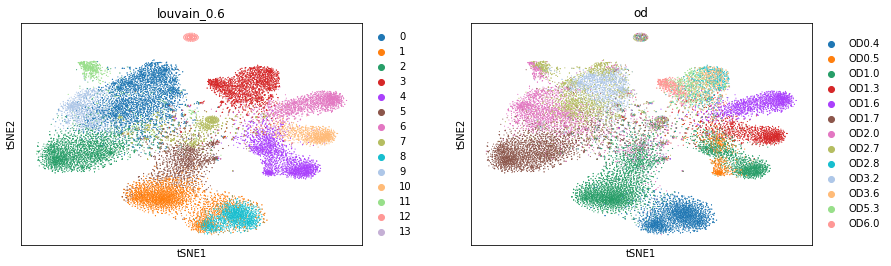

In [ ]:
sc.pl.tsne(bsub_batch_corrected, color=['louvain_0.6','od'],  wspace=0.2)

# MNN Correct batch correction

Highly variable genes: 16


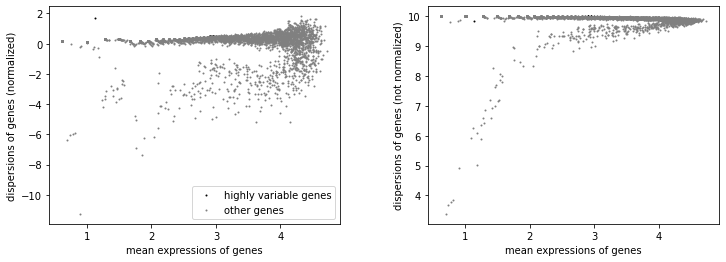

In [ ]:
# compute variable genes
sc.pp.highly_variable_genes(bsub1 , min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(bsub1.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(bsub1)

Highly variable genes: 27


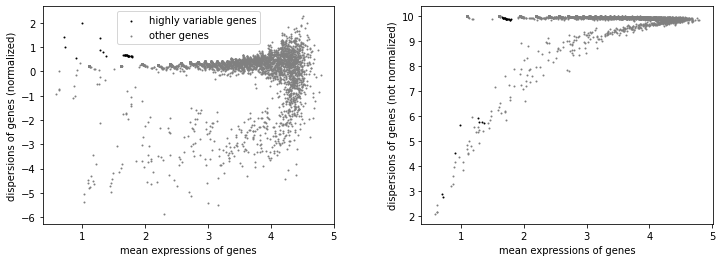

In [ ]:
# compute variable genes
sc.pp.highly_variable_genes(bsub2 , min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(bsub2.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(bsub2)

In [ ]:
bsub1_copy = bsub1.copy()
bsub1_copy

AnnData object with n_obs × n_vars = 25446 × 3769
    obs: 'od', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
bsub2_copy = bsub2.copy()
bsub2_copy

AnnData object with n_obs × n_vars = 10972 × 3666
    obs: 'od', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
gene_1 = np.where(bsub1_copy.var['highly_variable'] == True,
                  bsub1_copy.var['gene_names'],
                  '')

a1 = np.array([i for i in gene_1 if i])

print(a1)

['yrkQ_BSUBT' 'yraL_BSUBT' 'sdpB_BSUBT' 'pyrD_BSUBT' 'yoaC_BSUBT'
 'yxlC_BSUBT' 'yhaU_BSUBT' 'gbsA_BSUBT' 'yqgV_BSUBT' 'sacY_BSUBT'
 'nupN_BSUBT' 'hutH_BSUBT' 'xkdQ_BSUBT' 'xkdP_BSUBT' 'ydcA_BSUBT'
 'spoIISB_BSUBT']


In [ ]:
gene_2 = np.where(bsub2_copy.var['highly_variable'] == True,
                  bsub2_copy.var['gene_names'],
                  '')

a2 = np.array([i for i in gene_2 if i])

print(a2)

['ahpF_BSUBT' 'tufA_BSUBT' 'pdhA_BSUBT' 'rpoA_BSUBT' 'adk_BSUBT'
 'pdhC_BSUBT' 'sufB_BSUBT' 'gapA_BSUBT' 'ylaE_BSUBT' 'opuBC_BSUBT'
 'phrK_BSUBT' 'yjgB_BSUBT' 'tuaC_BSUBT' 'ybcF_BSUBT' 'gerKB_BSUBT'
 'opuBD_BSUBT' 'ynzC_BSUBT' 'yvaD_BSUBT' 'hisD_BSUBT' 'bacA_BSUBT'
 'ydzU_BSUBT' 'nupP_BSUBT' 'spoVR_BSUBT' 'ywmA_BSUBT' 'sigE_BSUBT'
 'yddR_BSUBT' 'spoIIB_BSUBT']


In [ ]:
overlap_genes = np.intersect1d(bsub1_copy.var['gene_names'],bsub2_copy.var['gene_names'])

In [ ]:
print(len(overlap_genes))

3587


In [ ]:
bsub1_filtered = bsub1_copy.copy()
genes_list = bsub1_copy.var['gene_names'].tolist();
idx = []
for gene in overlap_genes:
  t = genes_list.index(gene)
  idx.append(t)

bsub1_filtered = bsub1_filtered[:,idx]
bsub1_filtered

View of AnnData object with n_obs × n_vars = 25446 × 3587
    obs: 'od', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
bsub2_filtered = bsub2_copy.copy()
genes_list2 = bsub2_copy.var['gene_names'].tolist();
idx2 = []
for gene in overlap_genes:
  t = genes_list2.index(gene)
  idx2.append(t)

bsub2_filtered = bsub2_filtered[:,idx2]
bsub2_filtered

View of AnnData object with n_obs × n_vars = 10972 × 3587
    obs: 'od', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
bsub2_filtered.var_names = bsub2_filtered.var['gene_names']

In [ ]:
bsub1_filtered.var_names = bsub1_filtered.var['gene_names']

In [ ]:
# for mnn method 
datasets1 = [bsub1_filtered[bsub1_filtered.obs['od'] == ph].copy() for ph in bsub1_filtered.obs.od.cat.categories]
datasets2 = [bsub2_filtered[bsub2_filtered.obs['od'] == ph].copy() for ph in bsub2_filtered.obs.od.cat.categories]
datasets = datasets1 + datasets2

In [ ]:
# for methods that take one dataset 
bsub = bsub1_filtered.concatenate(bsub2_filtered, index_unique=None)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
x = bsub.obs['od'].to_numpy();
od_values = np.unique(x)
print(od_values)

bsub_comb_filtered = bsub.copy()
for od in od_values:
  t = np.array([(g == od) for g in bsub.obs['od']])
  idx = [i for i, x in enumerate(t) if x]
  counts = [bsub.obs['log1p_total_counts'][i] for i in idx]
  count_min = np.percentile(counts, 35)
  filter_idx = [idx[i] for i,x in enumerate(counts) if x < count_min]
  filter_idx = np.array(filter_idx)

  select = np.in1d(range(bsub_comb_filtered.shape[0]), filter_idx)
  bsub_comb_filtered  = bsub_comb_filtered[~select,:]

bsub_comb_filtered

['OD0.4' 'OD0.5' 'OD1.0' 'OD1.3' 'OD1.6' 'OD1.7' 'OD2.0' 'OD2.7' 'OD2.8'
 'OD3.2' 'OD3.6' 'OD5.3' 'OD6.0']


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 25803 × 3587
    obs: 'od', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch'
    var: 'gene_names', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'mean-0', 'std-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'mean-1', 'std-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_pca_harmony'

In [ ]:
datasets_mnn = [bsub_comb_filtered[bsub_comb_filtered.obs['batch'] == ph].copy() for ph in bsub_comb_filtered.obs.batch.cat.categories]
corrected_mnn = sc.external.pp.mnn_correct(*datasets_mnn,key='batch')

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/usr/local/lib/python3.7/dist-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/mnnpy/utils.py (94)

File "../usr/local/lib/python3.7/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../usr/local/lib/python3.7/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  state.func_ir.loc))
/usr/loc

  Computing correction vectors...


/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


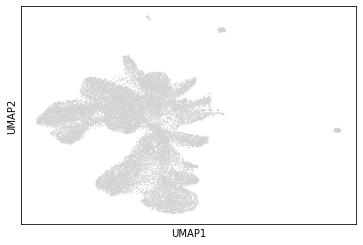

In [ ]:
sc.pp.neighbors(corrected_mnn[0], n_neighbors=45, n_pcs=9)
sc.tl.umap(corrected_mnn[0])
sc.pl.umap(corrected_mnn[0], color=['batch'])

In [ ]:
sc.tl.louvain(corrected_mnn[0], resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(corrected_mnn[0], resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(corrected_mnn[0], resolution = 0.8, key_added = "louvain_0.8")
sc.tl.louvain(corrected_mnn[0], resolution = 1, key_added = "louvain_r1")

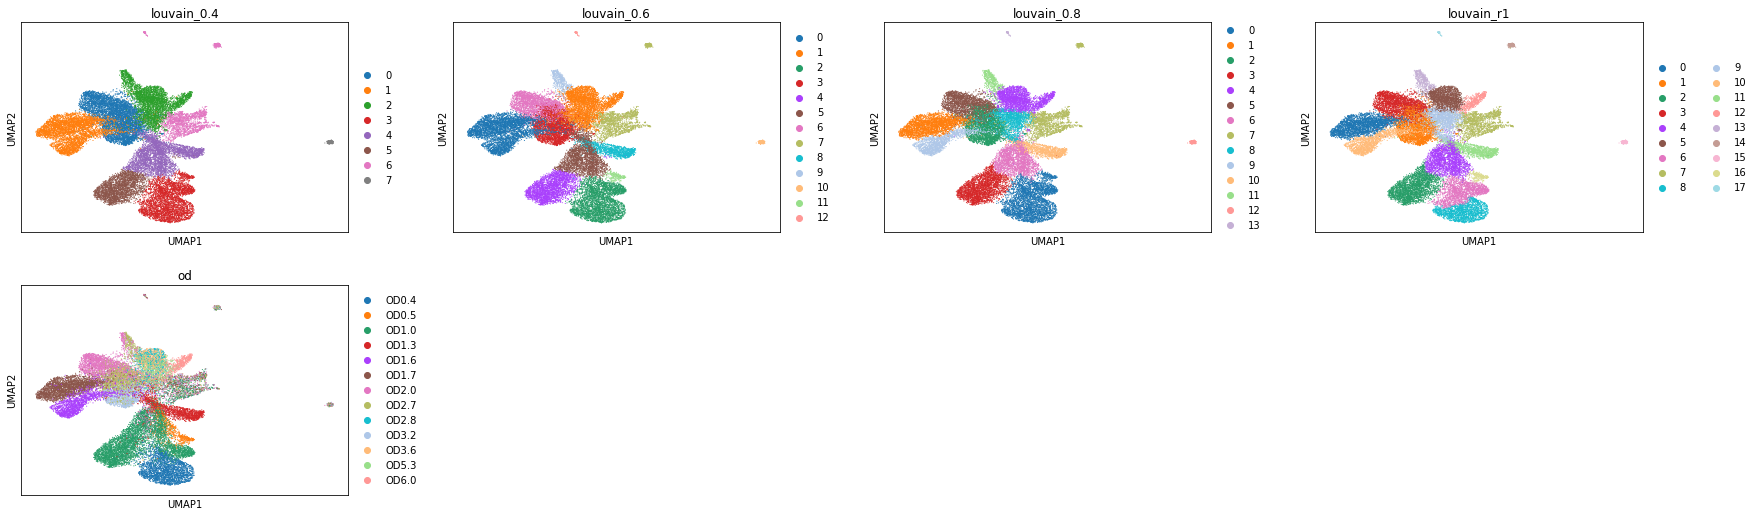

In [ ]:
sc.pl.umap(corrected_mnn[0], color=['louvain_0.4','louvain_0.6','louvain_0.8','louvain_r1','od'],  wspace=0.2)

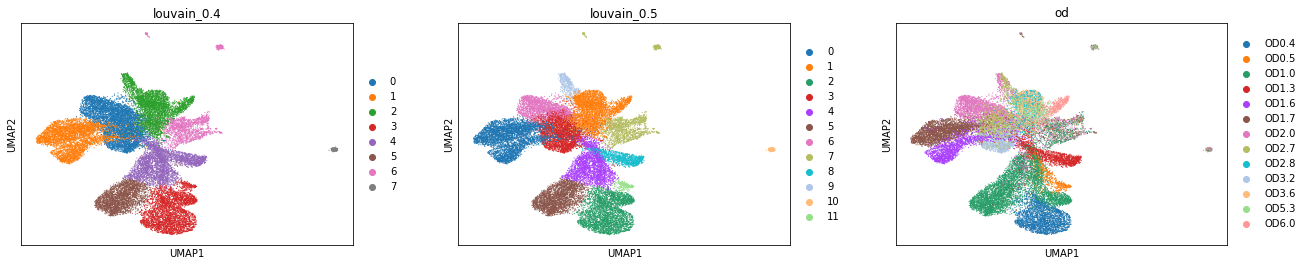

In [ ]:
sc.tl.louvain(corrected_mnn[0], resolution = 0.5, key_added = "louvain_0.5")
sc.pl.umap(corrected_mnn[0], color=['louvain_0.4','louvain_0.5','od'],  wspace=0.2)

# Harmony batch correction

In [ ]:
!pip install harmonypy

In [ ]:
bsub_comb_filtered_harmony = bsub_comb_filtered.copy()
sc.external.pp.harmony_integrate(bsub_comb_filtered_harmony,key='od')

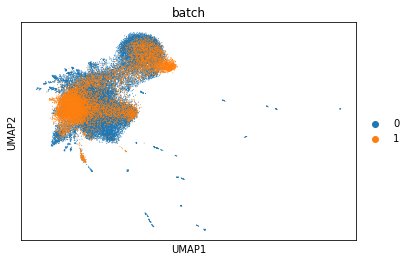

In [ ]:
sc.pp.neighbors(bsub, use_rep='X_pca_harmony', n_neighbors=45, n_pcs=9)
sc.tl.umap(bsub)
sc.pl.umap(bsub,color='batch')

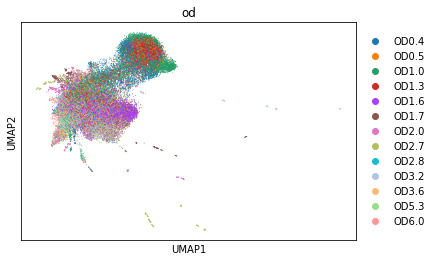

In [ ]:
sc.pl.umap(bsub,color='od')

In [ ]:
sc.pl.tsne(bsub_comb_filtered, color=['louvain_0.6','od'],  wspace=0.2)